# Final Project - Google Play Store App Analysis
## Ziyan Hu, Xiao Jin

In [39]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

### 1.Data Manipualtion
#### 1.1 read the data

In [40]:
# load the dataset
data = pd.read_csv('googleplaystore.csv')
reviews = pd.read_csv('googleplaystore_user_reviews.csv')

# display the first fews rows of data and inspect it
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [41]:
# display the first fews rows of reviews and inspect it
reviews.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


#### 1.2 Data Cleaning

In [42]:
# check for missing values in each column of 'data'
data.isnull().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

In [43]:
# check the missing values for 'reviews' dataset
reviews.isnull().sum()

App                           0
Translated_Review         26868
Sentiment                 26863
Sentiment_Polarity        26863
Sentiment_Subjectivity    26863
dtype: int64

In [44]:
# replace missing values in 'Rating' with the median value
median_rating = data['Rating'].median()
data['Rating'].fillna(median_rating, inplace=True)

# drop rows with missing values in 'Type', 'Content Rating', 'Current Ver', 'Android Ver'
data.dropna(subset=['Type', 'Content Rating', 'Current Ver', 'Android Ver'], inplace=True)

# drop rows with missing values in 'Translated_Review','Sentiment','Sentiment_Polarity' and 'Sentiment_Subjectivity'
reviews.dropna(subset=['Translated_Review','Sentiment','Sentiment_Polarity','Sentiment_Subjectivity'],inplace=True)

# drop the duplicate rows
data.drop_duplicates(inplace=True)
reviews.drop_duplicates(inplace=True)

In [45]:
# check the data type of each column
data.dtypes

App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

In [46]:
# convert 'Reviews' to numeric
data['Reviews'] = pd.to_numeric(data['Reviews'], errors='coerce')

# convert 'Installs' to numeric
data['Installs'] = data['Installs'].astype(str).str.replace(',', '', regex=False).str.replace('+', '', regex=False).astype(int)

# convert 'Size' to numeric
def convert_size(size):
    if 'M' in size:
        x = size[:-1]
        x = float(x)
        return(x)
    elif 'k' in size:
        x = size[:-1]
        x = float(x)/1000
        return(x)
    else:
        return None
data['Size'] = data['Size'].map(convert_size)

# fill 'Size' which had NA (Rows with Size == 'Varies with device' )
data.Size.fillna(method = 'ffill', inplace = True)  #('ffill method') propagates last valid observation forward to next valid

# remove '$' from 'Price' column
data["Price"] = data["Price"].astype(str).str.replace('$', '', regex=False)
data["Price"] = pd.to_numeric(data["Price"])

# drop columns 'Genres', 'Last Updated', 'Current Ver', 'Android Ver'
data= data.drop(['Genres', 'Last Updated', 'Current Ver', 'Android Ver'], axis=1)

#### 1.3 Merge two data frames

In [47]:
merged_data = pd.merge(reviews,data, on='App',how='inner')
merged_data = merged_data.drop(['Translated_Review'], axis = 1)
merged_data.head()

,App,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating
0,10 Best Foods for You,Positive,1.00,0.533333,HEALTH_AND_FITNESS,4.0,2490,3.8,500000,Free,0.0,Everyone 10+
1,10 Best Foods for You,Positive,0.25,0.288462,HEALTH_AND_FITNESS,4.0,2490,3.8,500000,Free,0.0,Everyone 10+
2,10 Best Foods for You,Positive,0.40,0.875000,HEALTH_AND_FITNESS,4.0,2490,3.8,500000,Free,0.0,Everyone 10+
3,10 Best Foods for You,Positive,1.00,0.300000,HEALTH_AND_FITNESS,4.0,2490,3.8,500000,Free,0.0,Everyone 10+
4,10 Best Foods for You,Positive,1.00,0.300000,HEALTH_AND_FITNESS,4.0,2490,3.8,500000,Free,0.0,Everyone 10+


### 2. Data Visualizations

#### 2.1 Google Store Apps Visualizations

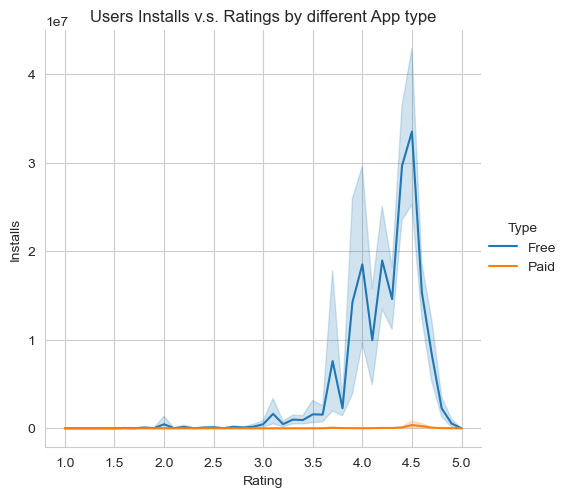

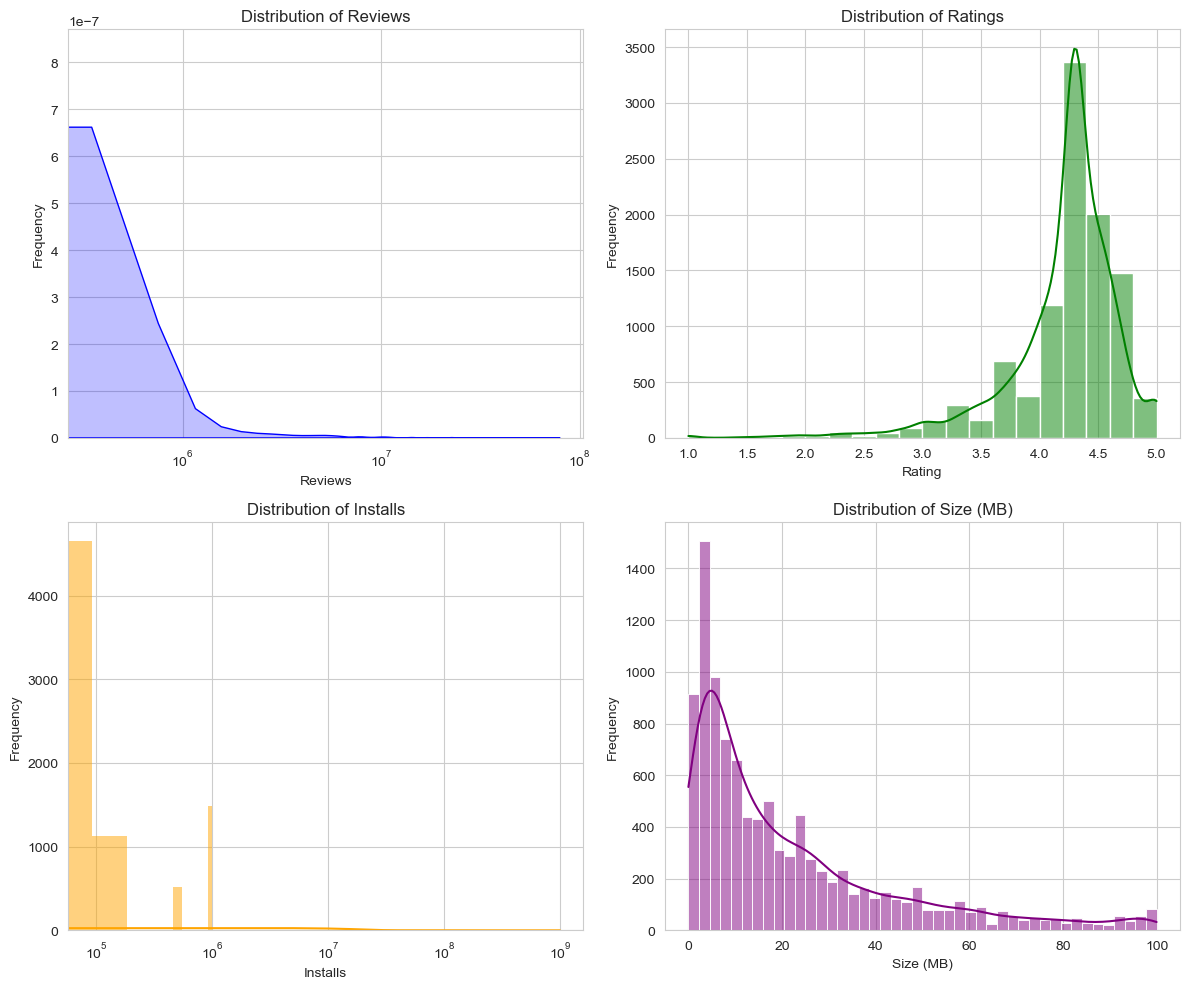

In [48]:
plt.figure(figsize=(12, 10))

# Distribution plot of Reviews
plt.subplot(2, 2, 1)
sns.kdeplot(data['Reviews'], color='blue', shade=True)
plt.title('Distribution of Reviews')
plt.xscale('log')  # Log scale due to wide range of values
plt.xlabel('Reviews')
plt.ylabel('Frequency')

# Distribution plot for Ratings
plt.subplot(2, 2, 2)
sns.histplot(data['Rating'], bins=20, kde=True, color='green')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')

# Distribution plot for Installs
plt.subplot(2, 2, 3)
sns.histplot(data['Installs'], kde=True, color='orange')
plt.title('Distribution of Installs')
plt.xscale('log')  # Log scale
plt.xlabel('Installs')
plt.ylabel('Frequency')

# Distribution plot for Size
plt.subplot(2, 2, 4)
sns.histplot(data['Size'], kde=True, color='purple')
plt.title('Distribution of Size (MB)')
plt.xlabel('Size (MB)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [49]:
# Rating v.s. Reviews
sns.relplot(x="Rating", y="Reviews", hue = 'Type' , kind = 'line' , data=data)
plt.title('Users Reviews v.s. Ratings by different type of App')

Text(0.5, 1.0, 'Users Reviews v.s. Ratings by different type of App')

In [50]:
# Rating v.s. Installs
sns.relplot(x="Rating", y="Installs", hue = 'Type' , kind = 'line' , data = data)
plt.title('Users Installs v.s. Ratings by different App type')

Text(0.5, 1.0, 'Users Installs v.s. Ratings by different App type')

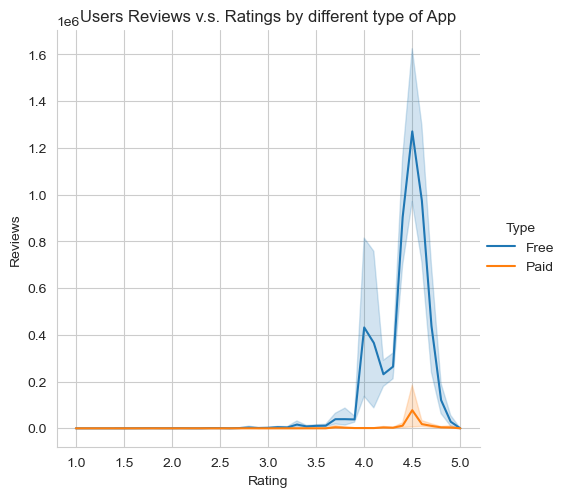

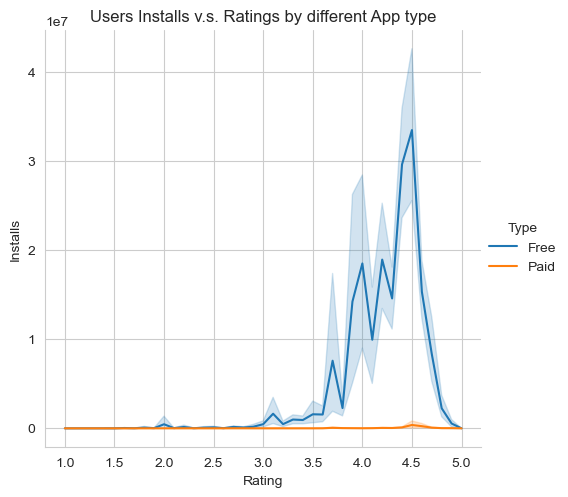

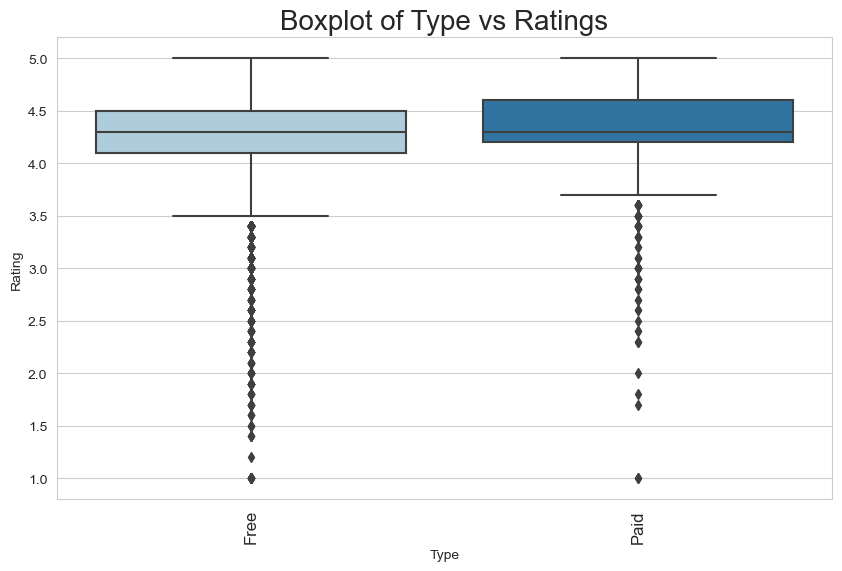

In [51]:
# Rating v.s. Type
plt.figure(figsize=(10, 6))
sns.boxplot(x="Type",y="Rating",data=data,palette = "Paired")
plt.xticks(rotation=90, fontsize=12)  # rotate x-axis for better displaying
plt.title('Boxplot of Type vs Ratings',size = 20)
plt.show()

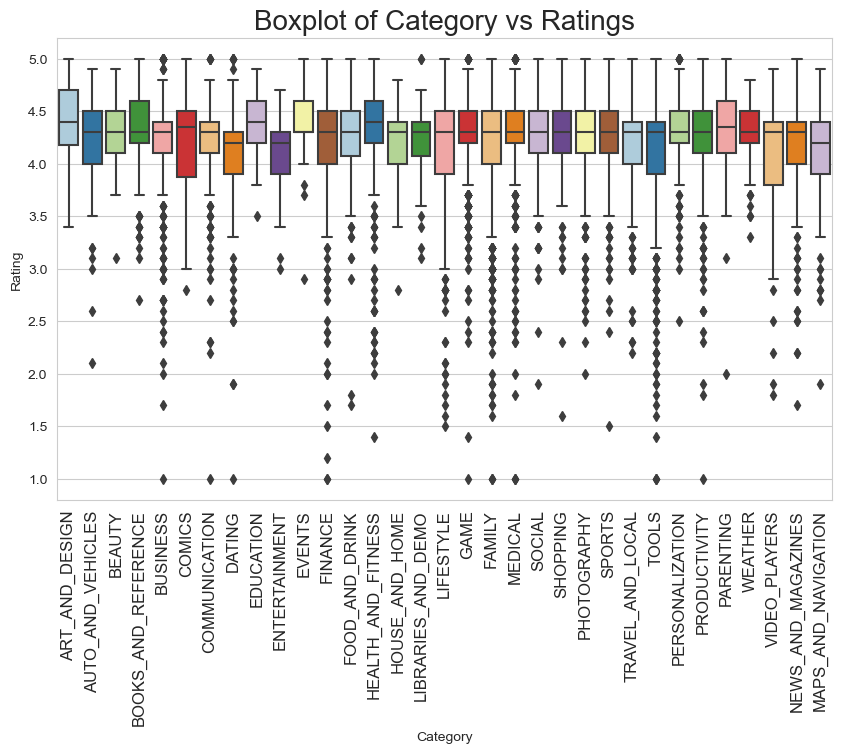

In [52]:
# Rating v.s. Category
plt.figure(figsize=(10, 6))
sns.boxplot(x="Category",y="Rating",data=data,palette = "Paired")
plt.xticks(rotation=90, fontsize=12)  # rotate x-axis for better displaying
plt.title('Boxplot of Category vs Ratings',size = 20)
plt.show()

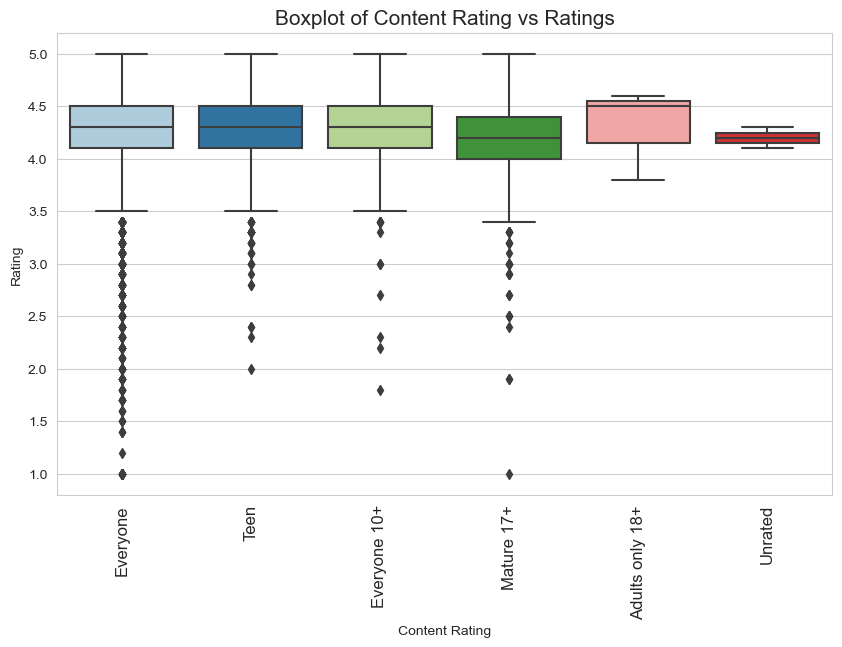

In [53]:
# Rating v.s. Content Rating
plt.figure(figsize=(10, 6))
sns.boxplot(x="Content Rating",y="Rating",data=data,palette = "Paired")
plt.xticks(rotation=90,fontsize=12)  # rotate x-axis for better displaying
plt.title('Boxplot of Content Rating vs Ratings',size = 15)
plt.show()

#### 2.2 Reviews Visualizations

In [54]:
plt.figure(figsize=(15, 6))
# Histogram of Sentiment Polarity
plt.subplot(1, 3, 1)
sns.histplot(reviews['Sentiment_Polarity'], bins=30, kde=True)
plt.title('Histogram of Sentiment Polarity')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')

# Bar plot of the distribution of Sentiment Categories
plt.subplot(1, 3, 3)
sns.countplot(x='Sentiment', data=reviews, palette='pastel')
plt.title('Distribution of Sentiment Categories')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Histogram for sentiment subjectivity
plt.subplot(1, 3, 2)
sns.histplot(reviews['Sentiment_Subjectivity'], bins=30, kde=True, color = 'indigo')
plt.title('Histogram of Sentiment Subjectivity')
plt.xlabel('Sentiment Subjectivity')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

#### Sentiment polarity & subjectivity by different app categories

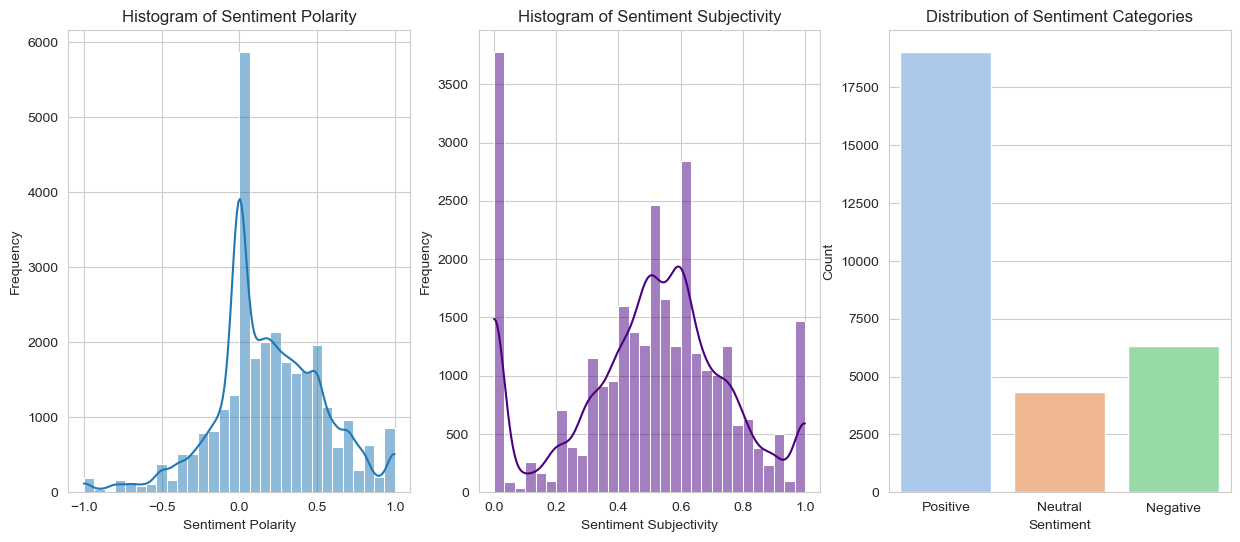

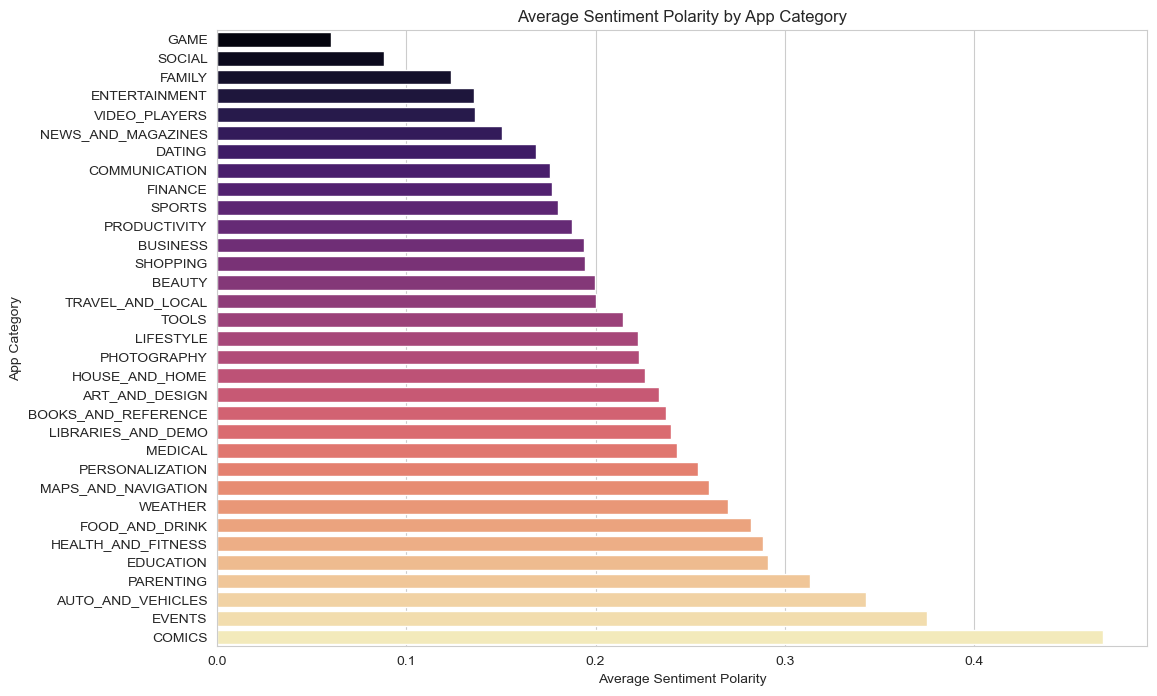

In [55]:
# plot sentiment polarity by App Category
avg_polarity_by_category = merged_data.groupby('Category')['Sentiment_Polarity'].mean().sort_values()
plt.figure(figsize=(12, 8))
sns.barplot(x=avg_polarity_by_category,y=avg_polarity_by_category.index,palette='magma')
plt.title('Average Sentiment Polarity by App Category')
plt.xlabel('Average Sentiment Polarity')
plt.ylabel('App Category')
plt.show()

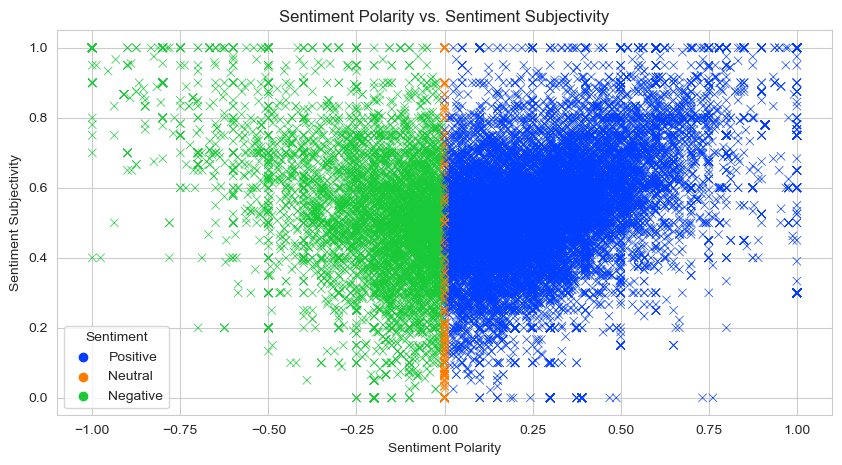

In [71]:
# plot the association between Sentiment Polarity and Sentiment Subjectivity
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Sentiment_Polarity', y='Sentiment_Subjectivity', hue='Sentiment', data=reviews, palette='bright', marker = 'x')
plt.title('Sentiment Polarity vs. Sentiment Subjectivity')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Sentiment Subjectivity')
plt.show()

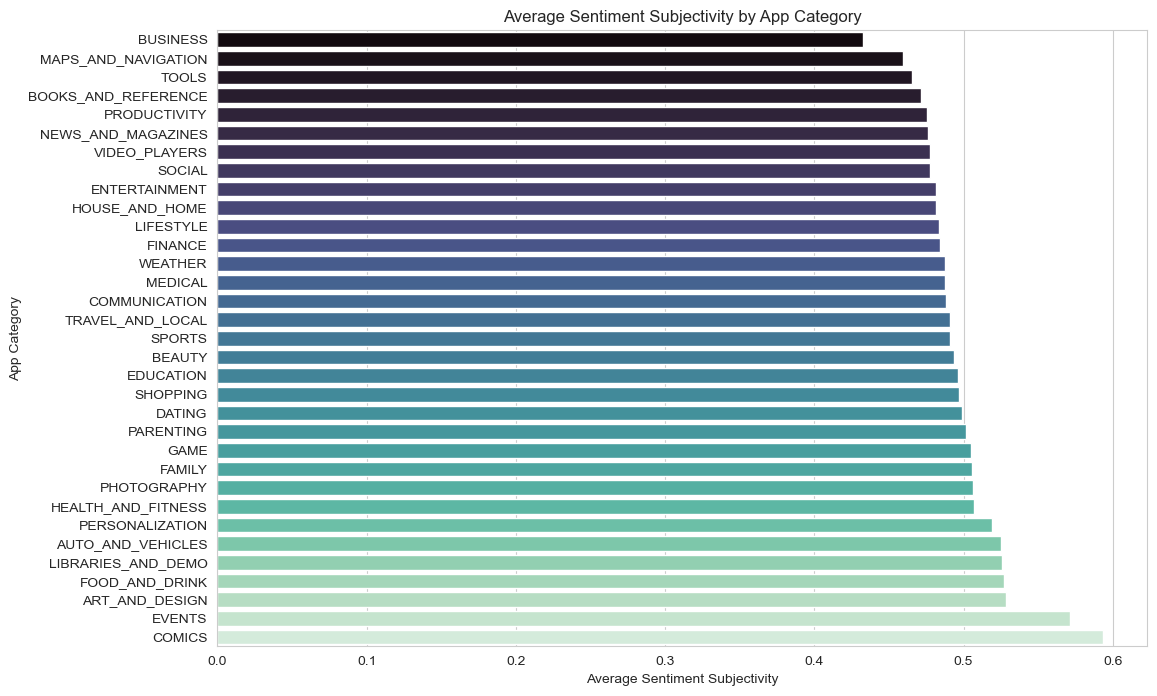

In [72]:
# plot sentiment subjectivity by App Category
avg_subjectivity_by_category = merged_data.groupby('Category')['Sentiment_Subjectivity'].mean().sort_values()
plt.figure(figsize=(12, 8))
sns.barplot(x=avg_subjectivity_by_category,y=avg_subjectivity_by_category.index,palette='mako')
plt.title('Average Sentiment Subjectivity by App Category')
plt.xlabel('Average Sentiment Subjectivity')
plt.ylabel('App Category')
plt.show()

<Figure size 1000x500 with 0 Axes>

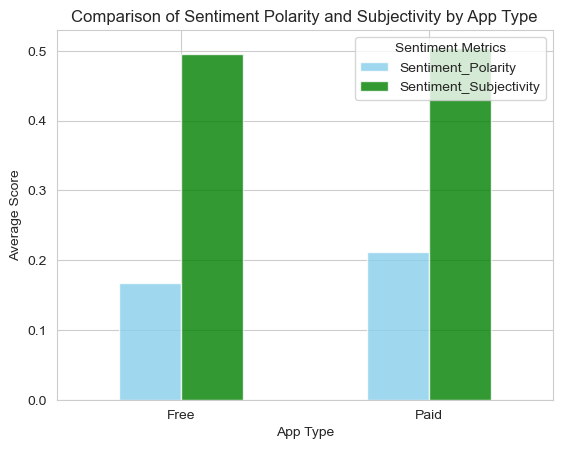

In [57]:
# Grouping data by Type (Free or Paid) and calculating average sentiment polarity and subjectivity
sentiment_by_app_type = merged_data.groupby('Type')[['Sentiment_Polarity', 'Sentiment_Subjectivity']].mean()

# Creating a bar plot
plt.figure(figsize=(10, 5))
sentiment_by_app_type.plot(kind='bar', color=['skyblue', 'green'], alpha=0.8)
plt.title('Comparison of Sentiment Polarity and Subjectivity by App Type')
plt.xlabel('App Type')
plt.ylabel('Average Score')
plt.xticks(rotation=0)
plt.legend(title='Sentiment Metrics')
plt.show()

### 3. Statistical Tests

#### 3.1 Influencing Factors on App Ratings

**Preliminary Analysis:**

In [58]:
# Normality Check for continuous variables (scipy.stats.normaltest)
# choose continuous independent variables
cont_variables = ['Reviews', 'Size', 'Installs', 'Price']
# Initialize a list to store test results
normality_test_results = []
# Perform normality test for each variable
for var in cont_variables:
    stat, p = stats.normaltest(data[var])
    normality_test_results.append({'Variable': var, 'Statistics': stat, 'p-value': p})

# Convert the results into a DataFrame for better visualization
normality_test_df = pd.DataFrame(normality_test_results)

# Display the results in a tabular format
print(normality_test_df)

   Variable    Statistics  p-value
0   Reviews  21290.007917      0.0
1      Size   2701.270219      0.0
2  Installs  16047.310527      0.0
3     Price  24083.001255      0.0


All continuous variables we are interested in are non-normal because all p-values are 0.0 which suggests that the probability of the observing data being normally distributed is extremely low. Therefore, we have strong evidence to reject the null hypothesis of normality.

In [59]:
# List of categorical variables for analysis
cat_variables = ['Category', 'Type', 'Content Rating']

# Function to check normality
def check_normality(data, group, variable):
    group_data = data[data[group] == variable]['Rating'].dropna()
    # Check if the group size is at least 3 for Shapiro-Wilk test
    if len(group_data) < 3:
        return None  # Not enough data to perform the test
    elif len(group_data) <= 30:  # Shapiro-Wilk test for smaller samples
        stat, p = stats.shapiro(group_data)
    else:  # D'Agostino's K-squared test for larger samples
        stat, p = stats.normaltest(group_data)
    return p > 0.05  # Returns True if normally distributed (alpha level of 0.05)

# Analyze each categorical variable
for cat_var in cat_variables:
    print(f'\nAnalyzing "{cat_var}" against Ratings:')

    # Check normality within each category
    categories = data[cat_var].unique()
    normality_results = {category: check_normality(data, cat_var, category) for category in categories}

    # Print normality results for each category
    for category, is_normal in normality_results.items():
        if is_normal:
            print(f'  Category "{category}" in "{cat_var}" is normally distributed.')
        else:
            print(f'  Category "{category}" in "{cat_var}" is NOT normally distributed.')

    # If all groups are normally distributed, use ANOVA, else use Kruskal-Wallis
    if all(normality_results.values()):
        print(f'All groups in "{cat_var}" are approximately normally distributed. Suggesting ANOVA.')
    else:
        print(f'Not all groups in "{cat_var}" are normally distributed. Suggesting Kruskal-Wallis.')


Analyzing "Category" against Ratings:
  Category "ART_AND_DESIGN" in "Category" is normally distributed.
  Category "AUTO_AND_VEHICLES" in "Category" is NOT normally distributed.
  Category "BEAUTY" in "Category" is NOT normally distributed.
  Category "BOOKS_AND_REFERENCE" in "Category" is NOT normally distributed.
  Category "BUSINESS" in "Category" is NOT normally distributed.
  Category "COMICS" in "Category" is NOT normally distributed.
  Category "COMMUNICATION" in "Category" is NOT normally distributed.
  Category "DATING" in "Category" is NOT normally distributed.
  Category "EDUCATION" in "Category" is normally distributed.
  Category "ENTERTAINMENT" in "Category" is NOT normally distributed.
  Category "EVENTS" in "Category" is NOT normally distributed.
  Category "FINANCE" in "Category" is NOT normally distributed.
  Category "FOOD_AND_DRINK" in "Category" is NOT normally distributed.
  Category "HEALTH_AND_FITNESS" in "Category" is NOT normally distributed.
  Category "HOU

**Correlation Analysis:**

In [60]:
# Perform Spearman correlation for each continuous variable against 'Rating'
for var in cont_variables:

    # Calculate Spearman correlation
    corr_coef, p_value = stats.spearmanr(data[var], data['Rating'])
    print(f'Spearman correlation between Rating and {var}: Correlation Coefficient={corr_coef}, p-value={p_value}')

Spearman correlation between Rating and Reviews: Correlation Coefficient=0.1139282541096425, p-value=3.0863828390413794e-31
Spearman correlation between Rating and Size: Correlation Coefficient=0.06382103901696058, p-value=8.171172475103112e-11
Spearman correlation between Rating and Installs: Correlation Coefficient=0.03893185727160502, p-value=7.464021365165582e-05
Spearman correlation between Rating and Price: Correlation Coefficient=0.056885503512663506, p-value=7.03382817736611e-09


- All correlations are statistically significant, but they are all quite weak in strength. This indicates that although there is some degree of association between these variables and app ratings, other factors not included in this analysis may have a more substantial impact on the ratings.
- 
The statistical significance (low p-values) implies that the results are unlikely to have occurred by chance, but the weak correlations mean that the practical implications of these relationships may be limited
- 
These results highlight the importance of considering a range of factors when trying to understand what influences app ratings, as no single factor among those analyzed shows a strong correlation.

**Categorical Analysis:**

In [61]:
# Kruskal-Wallis test for each categorical variable
for cat_var in cat_variables:
    # Create a list of arrays, each containing the 'Rating' values for a category
    groups = [data[data[cat_var] == category]['Rating'].dropna() for category in data[cat_var].unique()]
    
    # Perform the Kruskal-Wallis test
    stat, p = stats.kruskal(*groups)
    print(f'Kruskal-Wallis test for {cat_var}: Statistic={stat}, p-value={p}')

Kruskal-Wallis test for Category: Statistic=286.02056096797327, p-value=1.4228705404587052e-42
Kruskal-Wallis test for Type: Statistic=34.53909476724463, p-value=4.177755554670008e-09
Kruskal-Wallis test for Content Rating: Statistic=21.592434121247145, p-value=0.0006257202686556843


- For all three categorical variables ('Category', 'Type', and 'Content Rating'), the Kruskal-Wallis test shows statistically significant differences in the distribution of app ratings.
These results suggest that app ratings are influenced by the category of the app, its type (free or paid), and the content rating.
- However, the Kruskal-Wallis test does not specify which specific groups within these categories differ from each other. If we want to find out which specific categories, types, or content ratings are different, you would need to conduct post-hoc pairwise comparisons.
- The extremely low p-values, especially for 'Category' and 'Type', indicate strong evidence against the null hypothesis of equal distributions, pointing towards meaningful differences in app ratings based on these categorical variables.

#### 3.2 Variation in User Sentiment

**Sentiment Analysis:**

In [62]:
_, p_value_polarity = stats.normaltest(merged_data['Sentiment_Polarity'].dropna())
_, p_value_subjectivity = stats.normaltest(merged_data['Sentiment_Subjectivity'].dropna())

print(f'Polarity normality test p-value: {p_value_polarity}')
print(f'Subjectivity normality test p-value: {p_value_subjectivity}')

Polarity normality test p-value: 2.358415472095148e-118
Subjectivity normality test p-value: 1.5104092367202866e-149


Since the p-values are extremely small in both cases, we have confidence to reject the null hypothesis and conclude that the distributions of both Sentiment Polarity and Sentiment Subjectivity are not normal. Type was already assessed above which is non-normal in both cases.

**Comparative Tests:**

In [63]:
# compare the sentiment between free and paid apps using the Mann-Whitney U test
# Mann-Whitney U test for Sentiment Polarity between Free and Paid Apps
free = merged_data[merged_data["Type"] == "Free"]
paid = merged_data[merged_data["Type"] == "Paid"]
stat, p = stats.mannwhitneyu(free["Sentiment_Polarity"].dropna(), paid["Sentiment_Polarity"])
print(f'Sentiment Polarity between Free and Paid Apps: Statistic={stat}, p-value={p}')

# Mann-Whitney U test for Sentiment Subjectivity between Free and Paid Apps
stat, p = stats.mannwhitneyu(free["Sentiment_Subjectivity"].dropna(), paid["Sentiment_Subjectivity"])
print(f'Sentiment Subjectivity between Free and Paid Apps: Statistic={stat}, p-value={p}')

Sentiment Polarity between Free and Paid Apps: Statistic=6718291.5, p-value=0.0019922172193271312
Sentiment Subjectivity between Free and Paid Apps: Statistic=7408919.5, p-value=0.9972155524181707


The test showed a statistically significant difference in sentiment polarity between the two groups, with a p-value of 0.002. This suggests that there is a significant variation in how positive or negative user sentiments are expressed between free and paid apps. On the other hand, when examining sentiment subjectivity, the test produced a p-value of approximately 1 (0.997), indicating that there is no significant difference in the subjectivity of user sentiments between free and paid apps.
Thus, based on the Mann-Whitney U test results, it appears that the "Type" (free or paid) of the apps only has a significant influence on the sentiment polarity of user reviews. 

**Category-Based Analysis:**

In [64]:
# Define the columns for app categories, sentiment polarity, and sentiment subjectivity
category_column = 'Category'
polarity_column = 'Sentiment_Polarity'
subjectivity_column = 'Sentiment_Subjectivity'

# Group data by app category
category_groups = merged_data.groupby('Category')

# Create empty lists to store data for each category
polarity_data = []
subjectivity_data = []

# Iterate through each category group
for category, group_data in category_groups:
    # Append sentiment polarity and subjectivity data for the current category
    polarity_data.append(group_data['Sentiment_Polarity'])
    subjectivity_data.append(group_data['Sentiment_Subjectivity'])

# Perform Kruskal-Wallis test for Sentiment Polarity
h_statistic_polarity, p_value_polarity = stats.kruskal(*polarity_data)

# Perform Kruskal-Wallis test for Sentiment Subjectivity
h_statistic_subjectivity, p_value_subjectivity = stats.kruskal(*subjectivity_data)

# Print the results for Sentiment Polarity
print(f'Kruskal-Wallis H-statistic for Sentiment Polarity: {h_statistic_polarity}')
print(f'p-value for Sentiment Polarity: {p_value_polarity}')

# Print the results for Sentiment Subjectivity
print(f'Kruskal-Wallis H-statistic for Sentiment Subjectivity: {h_statistic_subjectivity}')
print(f'p-value for Sentiment Subjectivity: {p_value_subjectivity}')

Kruskal-Wallis H-statistic for Sentiment Polarity: 2387.967116956822
p-value for Sentiment Polarity: 0.0
Kruskal-Wallis H-statistic for Sentiment Subjectivity: 204.0878722083291
p-value for Sentiment Subjectivity: 5.839853281847691e-27


In both cases, the extremely small p-values provide strong evidence that there are significant differences in sentiment (both polarity and subjectivity) across different app categories. 

In [65]:
# Define a function to perform Mann-Whitney U tests for a pair of categories
def perform_mannwhitneyu(data, category1, category2):
    group1 = data[data['Category'] == category1]['Sentiment_Polarity']
    group2 = data[data['Category'] == category2]['Sentiment_Polarity']
    
    # Check if both groups have data before performing the test
    if len(group1) > 0 and len(group2) > 0:
        _, p_value = stats.mannwhitneyu(group1, group2)
        return p_value
    else:
        return None

# Get unique categories
unique_categories = merged_data['Category'].unique()

# Initialize dictionaries to store positive and negative sentiment p-values
positive_sentiment_pvalues = {}
negative_sentiment_pvalues = {}

# Iterate through unique categories to calculate p-values
for i in range(len(unique_categories)):
    for j in range(i + 1, len(unique_categories)):
        category1 = unique_categories[i]
        category2 = unique_categories[j]
        p_value = perform_mannwhitneyu(merged_data, category1, category2)
        if p_value is not None:
            if p_value < 0.05:  # You can adjust the significance level as needed
                if p_value > 0.5:
                    positive_sentiment_pvalues[(category1, category2)] = p_value
                else:
                    negative_sentiment_pvalues[(category1, category2)] = p_value

# Sort categories by the average p-value for positive sentiment
sorted_positive_categories = sorted(unique_categories, key=lambda x: np.mean([positive_sentiment_pvalues.get((x, y), 0) for y in unique_categories]))

# Sort categories by the average p-value for negative sentiment
sorted_negative_categories = sorted(unique_categories, key=lambda x: np.mean([negative_sentiment_pvalues.get((x, y), 0) for y in unique_categories]))

# Print the category that tends to receive most positive sentiments
most_positive_category = sorted_positive_categories[0]
print(f"Category that tends to receive most positive sentiments: {most_positive_category}")

# Print the category that tends to receive most negative sentiments
most_negative_category = sorted_negative_categories[0]
print(f"Category that tends to receive most negative sentiments: {most_negative_category}")

# Print the sorted list of categories from most positive to most negative
print("\nCategories Sorted by Sentiment (from most positive to most negative):")
for category in sorted_positive_categories:
    print(category)

Category that tends to receive most positive sentiments: HEALTH_AND_FITNESS
Category that tends to receive most negative sentiments: COMICS

Categories Sorted by Sentiment (from most positive to most negative):
HEALTH_AND_FITNESS
SHOPPING
MEDICAL
GAME
PERSONALIZATION
DATING
TRAVEL_AND_LOCAL
COMMUNICATION
SPORTS
LIFESTYLE
PRODUCTIVITY
FAMILY
ENTERTAINMENT
PHOTOGRAPHY
FINANCE
NEWS_AND_MAGAZINES
EDUCATION
WEATHER
TOOLS
BUSINESS
MAPS_AND_NAVIGATION
BOOKS_AND_REFERENCE
HOUSE_AND_HOME
EVENTS
SOCIAL
VIDEO_PLAYERS
FOOD_AND_DRINK
PARENTING
AUTO_AND_VEHICLES
ART_AND_DESIGN
LIBRARIES_AND_DEMO
BEAUTY
COMICS


### 4. Other Types of Analysis


#### 4.1 App Rating Influencers

**Regression Analysis:**

In [66]:
# Define your dependent and independent variables
X = data[['Reviews', 'Installs', 'Price', 'Size']].copy()

# Copying categorical columns using .loc
X.loc[:, 'Category'] = data['Category']
X.loc[:, 'Type'] = data['Type']
X.loc[:, 'Content Rating'] = data['Content Rating']

# Convert categorical variables to dummy variables
X = pd.get_dummies(data=X, columns=['Category', 'Type', 'Content Rating'], drop_first=True)

# Add a constant term for the intercept
X = sm.add_constant(X)

# Define the dependent variable
y = data['Rating']

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Get the summary of the regression analysis
summary = model.summary()

# Print the summary
print(summary)

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     7.910
Date:                Wed, 13 Dec 2023   Prob (F-statistic):           6.60e-46
Time:                        14:09:57   Log-Likelihood:                -7044.8
No. Observations:               10346   AIC:                         1.418e+04
Df Residuals:                   10303   BIC:                         1.449e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

The OLS regression results show that the model explains only about 3.1% of the variability in app ratings (R-squared: 0.031), indicating limited explanatory power. The F-statistic (7.910) and its associated p-value (6.60e-46) suggest the model is statistically significant overall. Coefficients for variables like Reviews, Installs, Price, and Size show their respective impacts on app ratings. Notably, several category variables are statistically significant, indicating differences in ratings across app categories. The Durbin-Watson statistic (1.833) implies no serious autocorrelation issues in the residuals. However, tests for normality (Omnibus, Jarque-Bera) indicate that residuals are not normally distributed. The high condition number (1.22e+10) points to potential multicollinearity issues. Overall, while the model is significant, its low R-squared, issues with normality, and potential multicollinearity suggest the need for further refinement or exploration of additional variables.

**Feature Importance:**

In [67]:
# Prepare the Data
X = pd.get_dummies(data[['Reviews', 'Installs', 'Price', 'Size', 'Category', 'Type', 'Content Rating']])
y = data['Rating']

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Feature Importance
feature_importances = pd.Series(model.feature_importances_, index=X.columns)

# Evaluate the Model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Feature Importances:\n", feature_importances.sort_values(ascending=False))

Mean Squared Error: 0.20837473523162656
Feature Importances:
 Reviews                           0.328970
Size                              0.286657
Installs                          0.103949
Category_FAMILY                   0.022089
Price                             0.019003
Category_TOOLS                    0.014578
Category_LIFESTYLE                0.013989
Category_FINANCE                  0.013591
Category_MEDICAL                  0.012770
Category_HEALTH_AND_FITNESS       0.011512
Category_GAME                     0.010794
Content Rating_Everyone           0.010652
Category_BUSINESS                 0.009911
Category_PRODUCTIVITY             0.008925
Category_PHOTOGRAPHY              0.008240
Category_SPORTS                   0.007797
Content Rating_Teen               0.007358
Category_TRAVEL_AND_LOCAL         0.007302
Category_COMMUNICATION            0.007239
Category_VIDEO_PLAYERS            0.007045
Category_FOOD_AND_DRINK           0.006825
Category_DATING                   0

The RandomForestRegressor model's Mean Squared Error of 0.2084 indicates a moderate level of prediction accuracy for app ratings. The most significant predictors are 'Reviews' (32.9%) and 'Size' (28.7%), highlighting the importance of user engagement and app size in determining ratings. 'Installs' also plays a notable role (10.4%), while 'Price' has a relatively minor influence (1.9%). Categories like 'Family' and 'Tools' show some impact, but less than the primary factors. Overall, user interaction and app characteristics emerge as key determinants in app ratings.

#### User Sentiment Analysis

**Cluster Analysis:**

In [68]:
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.show()

NameError: name 'X_scaled' is not defined

In [ ]:
features = merged_data[['Sentiment_Polarity', 'Sentiment_Subjectivity']]

# Using KMeans to cluster the data into k clusters
kmeans = KMeans(n_clusters = 3, n_init = 10).fit(features)

# Predicting the clusters
labels = kmeans.predict(features)

# Adding the cluster labels to our dataframe
merged_data['Cluster'] = labels

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['Sentiment_Polarity'], merged_data['Sentiment_Subjectivity'], c=merged_data['Cluster'], cmap='viridis')
plt.title('K-Means Clustering of App Sentiments')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Sentiment Subjectivity')
plt.colorbar(label='Cluster')
plt.show()


The plot reveals three distinct clusters: the first in yellow, where sentiment polarity is negative and subjectivity varies; notably, as sentiments become more negative, subjectivity tends to decrease within this cluster. The second cluster, in purple, is at the top right, characterized by positive sentiment polarities with a broad range of subjectivity that increases as the sentiments become more positive. The final cluster, in green, bridges the gap between the first two, situated in the neutral zone with a moderate spread of sentiment subjectivity.